In [1]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

# Practical Session - Planning in bandits/MDP

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from tictactoe_env import TicTacToeEnv, DRAW
from utils import play, Agent, agent_vs_agent

# Part II -  Monte Carlo Tree Search

In this practical session, we will implement several MCTS heuristics and compare them. To do so, we will use a  Tic Tac Toe environement.

## Tic Tac Toe environment

TicTacToeEnv is a custom envirionment based on the OpenAI gym library.

Disclaimer: this implementation is *not* optimal and rather slow (due to copying heavy gym objects in many places). The goal here is to be pedagogical, not time-efficient. Don't think MCTS is necessarily slow in general!

In [3]:
env = TicTacToeEnv()
env.render()

# # #    |   1 2 3 
# # #    |   4 5 6 
# # #    |   7 8 9 




### Manual play

In [4]:
# Example game: each player plays randomly

# Always reset the environment at the start of a game
# (Remark : the reset method returns the initial state 
# of the envionment, i.e the board in the present case)
env.reset()
done = False
while not done:
    # Draw a position uniformly at random among the
    # remaining possible choices
    pos = env.sample()
    board, reward, done, _ = env.step(pos)
    # Display the board
    env.render()

winner = board.check_state()
if winner == DRAW:
    print("**      DRAW      **")
elif winner == 1:
    print("**      O WINS      **")
else:
    print("**      X WINS      **")

O # #    |   1 2 3 
# # #    |   4 5 6 
# # #    |   7 8 9 


O # X    |   1 2 3 
# # #    |   4 5 6 
# # #    |   7 8 9 


O # X    |   1 2 3 
# # #    |   4 5 6 
# # O    |   7 8 9 


O # X    |   1 2 3 
# X #    |   4 5 6 
# # O    |   7 8 9 


O O X    |   1 2 3 
# X #    |   4 5 6 
# # O    |   7 8 9 


O O X    |   1 2 3 
# X #    |   4 5 6 
# X O    |   7 8 9 


O O X    |   1 2 3 
# X O    |   4 5 6 
# X O    |   7 8 9 


O O X    |   1 2 3 
X X O    |   4 5 6 
# X O    |   7 8 9 


O O X    |   1 2 3 
X X O    |   4 5 6 
O X O    |   7 8 9 


**      DRAW      **


## Implementing a dummy agent

In [5]:
class DummyAgent(Agent):
    """Dummy TicTacToe agent that plays randomly.
    """
    def __init__(self, env, player=1, params={}):
        self._env = env
        self.player = player  # index of the player

    def play(self):
        """Syntax: play should be a method with no argument
        except self.
        In the present example, it simply calls the env attribute
        and use it to sample a feasible action.
        """
        return self.env.sample()

In [6]:
# Available input in the API: [1-9], 'quit', 'switch'
play(DummyAgent, game_env=env)

**        Tic Tac Toe Game        **
You are player 1 and you play the symbol O


# # #    |   1 2 3 
# # #    |   4 5 6 
# # #    |   7 8 9 
Where do you want to play? 
Unkown action, quitting...


## Pitting two agents against one another 

100%|██████████| 100/100 [00:00<00:00, 188.92it/s, draw=14%, 0 wins=58%, X wins=28%]


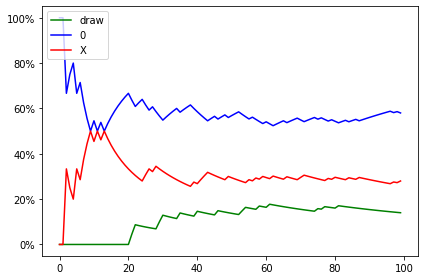

In [7]:
agent_vs_agent(env, DummyAgent, DummyAgent, n_episodes=100, params1={}, params2={}, plot=True)

### Question 1

Comment the results of random vs random above. How do you explain that 'O' has the advantage despite playing at random?

## Q-Learning agent

### Question 2

Recall what Q-learning is.

In **qlearning.py**, the Q-learning update rule is missing from the functions Q_learning_vs_random and random_vs_Q_learning. Complete them.

In [9]:
from qlearning import QFunction, QLearningAgent, random_vs_Q_learning, Q_learning_vs_random

GAMMA = 0.99
n_episodes = int(1e4)
learning_rate = 0.05
epsilon_greedy = 0.9
epsilon_greedy_decay_freq = 50
epsilon_greedy_decay_factor = 0.9

Q_opt_Q_learning_cross, stats = random_vs_Q_learning(
    env,
    n_episodes,
    learning_rate,
    epsilon_greedy,
    epsilon_greedy_decay_freq,
    epsilon_greedy_decay_factor,
    gamma=GAMMA,
)

Q_opt_Q_learning_nought, stats = Q_learning_vs_random(
    env,
    n_episodes,
    learning_rate,
    epsilon_greedy,
    epsilon_greedy_decay_freq,
    epsilon_greedy_decay_factor,
    gamma=GAMMA,
)

100%|██████████| 10000/10000 [00:25<00:00, 397.79it/s, draw=9%, 0 wins=73%, X wins=18%]


In [10]:
play(QLearningAgent, game_env=env, params={'Q': Q_opt_Q_learning_cross.Q})

**        Tic Tac Toe Game        **
You are player 1 and you play the symbol O


# # #    |   1 2 3 
# # #    |   4 5 6 
# # #    |   7 8 9 
Where do you want to play? 
Unkown action, quitting...


### Question 3
Do you think Q-Learning is performing well on this game? Why?

Answer: tabular Q-Learning has no way to understand the turn-based structure of the game. As it cannot generalize from one state to another, it has to experience many different episodes to find a good policy, resulting in high sample complexity.

## Monte Carlo Tree Search

### Question 4
Recall and explain the idea behind MCTS and the four main steps of a MCTS.

Answers: Selection, Expansion, Simulation, Backpropagation.

A template class for MCTS is defined in **mcts.py**. It is an abstract class, and you need to instanciate the method search_heuristic, to guide the selection step of MCTS.

We first implement the uniform random search.

### Question 5

- Understand the pure exploration tree search heuristic implementation
- Implement the UCT algorithm

Feel free to experiment and implement other tree search policies (e.g., implement a pure exploitation tree search heuristic)

In [11]:
from mcts import MCTS

class MCTSPureExploration(MCTS):
    def __init__(self, player=1):
        super().__init__(player=player)

    def search_heuristic(self, node):
        """Pure exploration, uniformly choose how to
        explore the game tree.
        """
        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])
        
        return np.random.choice(list(self.children[node]))


class MCTSUCT(MCTS):
    def __init__(self, player=1, exploration_param=1.0):
        self.exploration_param = exploration_param
        super().__init__(player=player)

    def search_heuristic(self, node):
        """Upper Confidence bound for Trees.
        Balance exploration and exploitation in the game tree.
        """
        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])
        
        # children is a dictionary of node -> set of children,
        # where node is a TicTacToeEnv, and the chidlren are
        # TicTacToeEnv corresponding to boards that are 
        # one action away from node.
        
        # self.W is a dictionary of node -> backpropagated rewards
        # self.N is a dictionary of node -> backpropagated number of visits
        
        def uct(n):
            "Upper confidence bound for trees"
            return self.W[n] / self.N[n] + self.exploration_param * np.sqrt(
                np.log(self.N[node]) / self.N[n]
            )
        return max(self.children[node], key=uct)

In [12]:
class MCTSAgent(Agent):
    """TicTacToe template agent that plays according to MCTS.
    """
    def __init__(self, env, player=1, params={'n_playouts': 1}):
        self.env = env
        self.player = player  # index of the player
        self.n_playouts = params.get('n_playouts', 1)
        # To be implemented in child class
        self.game_tree = None 
        
    def play(self):
        """Syntax: play should be a method without argument
        except self.
        """
        # Need to copy environment, so that MCTS internal simulations
        # do not affect the game being played
        env_copy = deepcopy(env)
        for _ in range(self.n_playouts):
            self.game_tree.playout(env_copy)
        return self.game_tree.choose(env_copy)


class MCTSPureExplorationAgent(MCTSAgent):
    """TicTacToe agent that plays according to MCTS Pure Exploration.
    """
    def __init__(self, env, player=1, params={'n_playouts': 1}):
        super().__init__(env=env, player=player, params=params)
        self.game_tree = MCTSPureExploration(player=player)

        
class MCTSUCTAgent(MCTSAgent):
    """TicTacToe agent that plays according to MCTS UCT.
    """
    def __init__(self, env, player=1, params={'n_playouts': 1, 'exploration_param': 1.0}):
        super().__init__(env=env, player=player, params=params)
        exploration_param = params.get('exploration_param', 1.0)
        self.game_tree = MCTSUCT(player=player, exploration_param=exploration_param)

### Manual play

In [13]:
env.reset()

agent1 = DummyAgent(env, player=1)
agent2 = MCTSUCTAgent(env, player=2, params={'n_playouts': 20, 'exploration_param': 1.0})

n_episodes = 10

for episode in range(n_episodes):
    done = False
    _ = env.reset()
    turn = 0

    while not done:
        if turn % 2 == 0:
            action = agent1.play()
        else:
            action = agent2.play()

        _, _, done, _ = env.step(action)

        turn += 1

        if done:
            break

    winner = env.board.check_state()
    if winner == DRAW:
        print("**      DRAW        **")
    elif winner == 1:
        print("**      O WINS      **")
    else:
        print("**      X WINS      **")

**      X WINS      **
**      X WINS      **
**      X WINS      **
**      X WINS      **
**      X WINS      **
**      X WINS      **
**      X WINS      **
**      X WINS      **
**      DRAW        **
**      X WINS      **


### Question 6
Interpret the output of the next cell. What does it represent?

Answer: it represent the tree discovered after several rollouts by the MCTS algorithm.

In [14]:
game_tree = agent2.game_tree
children = game_tree.children
print('Total number of nodes: {}\n'.format(len(children)))
for node, successors in children.items():
    print('Node: {} wins, {} visits'.format(game_tree.W[node], game_tree.N[node]))
    node.render()
    for successor in successors:
        print('Child: {} wins, {} visits'.format(game_tree.W[successor], game_tree.N[successor]))
        successor.render()
    print('----------------------\n\n')

Total number of nodes: 561

Node: 4.0 wins, 20 visits
# # #    |   1 2 3 
# # #    |   4 5 6 
O # #    |   7 8 9 


Child: 2.0 wins, 4 visits
# # #    |   1 2 3 
# X #    |   4 5 6 
O # #    |   7 8 9 


Child: 0.5 wins, 2 visits
# # X    |   1 2 3 
# # #    |   4 5 6 
O # #    |   7 8 9 


Child: 0 wins, 2 visits
# # #    |   1 2 3 
# # #    |   4 5 6 
O X #    |   7 8 9 


Child: 0.5 wins, 2 visits
# # #    |   1 2 3 
X # #    |   4 5 6 
O # #    |   7 8 9 


Child: 0 wins, 2 visits
# # #    |   1 2 3 
# # X    |   4 5 6 
O # #    |   7 8 9 


Child: 0 wins, 2 visits
# X #    |   1 2 3 
# # #    |   4 5 6 
O # #    |   7 8 9 


Child: 0 wins, 2 visits
# # #    |   1 2 3 
# # #    |   4 5 6 
O # X    |   7 8 9 


Child: 1 wins, 3 visits
X # #    |   1 2 3 
# # #    |   4 5 6 
O # #    |   7 8 9 


----------------------


Node: 2.0 wins, 4 visits
# # #    |   1 2 3 
# X #    |   4 5 6 
O # #    |   7 8 9 


Child: 0 wins, 1 visits
# # #    |   1 2 3 
# X #    |   4 5 6 
O # O    |   7

# O #    |   1 2 3 
# # #    |   4 5 6 
X # O    |   7 8 9 


Child: 0 wins, 0 visits
# O #    |   1 2 3 
# X #    |   4 5 6 
X # O    |   7 8 9 


Child: 0 wins, 0 visits
# O #    |   1 2 3 
# # #    |   4 5 6 
X X O    |   7 8 9 


Child: 0 wins, 0 visits
X O #    |   1 2 3 
# # #    |   4 5 6 
X # O    |   7 8 9 


Child: 0 wins, 0 visits
# O #    |   1 2 3 
# # X    |   4 5 6 
X # O    |   7 8 9 


Child: 0 wins, 0 visits
# O #    |   1 2 3 
X # #    |   4 5 6 
X # O    |   7 8 9 


Child: 0 wins, 0 visits
# O X    |   1 2 3 
# # #    |   4 5 6 
X # O    |   7 8 9 


----------------------


Node: 0 wins, 1 visits
# O #    |   1 2 3 
O # #    |   4 5 6 
# # X    |   7 8 9 


Child: 0 wins, 0 visits
# O #    |   1 2 3 
O # #    |   4 5 6 
X # X    |   7 8 9 


Child: 0 wins, 0 visits
# O #    |   1 2 3 
O X #    |   4 5 6 
# # X    |   7 8 9 


Child: 0 wins, 0 visits
# O #    |   1 2 3 
O # X    |   4 5 6 
# # X    |   7 8 9 


Child: 0 wins, 0 visits
X O #    |   1 2 3 
O # #    |

# # #    |   7 8 9 


Child: 0 wins, 0 visits
# O #    |   1 2 3 
O # X    |   4 5 6 
# # #    |   7 8 9 


Child: 0 wins, 0 visits
# # #    |   1 2 3 
O O X    |   4 5 6 
# # #    |   7 8 9 


Child: 0 wins, 0 visits
# # #    |   1 2 3 
O # X    |   4 5 6 
# O #    |   7 8 9 


Child: 0 wins, 0 visits
# # #    |   1 2 3 
O # X    |   4 5 6 
# # O    |   7 8 9 


Child: 0 wins, 0 visits
# # #    |   1 2 3 
O # X    |   4 5 6 
O # #    |   7 8 9 


Child: 0 wins, 0 visits
O # #    |   1 2 3 
O # X    |   4 5 6 
# # #    |   7 8 9 


----------------------


Node: 2 wins, 3 visits
# # #    |   1 2 3 
O # #    |   4 5 6 
# X #    |   7 8 9 


Child: 0 wins, 1 visits
# # #    |   1 2 3 
O # #    |   4 5 6 
# X O    |   7 8 9 


Child: 0 wins, 0 visits
# # #    |   1 2 3 
O # O    |   4 5 6 
# X #    |   7 8 9 


Child: 1 wins, 1 visits
# O #    |   1 2 3 
O # #    |   4 5 6 
# X #    |   7 8 9 


Child: 0 wins, 0 visits
# # #    |   1 2 3 
O # #    |   4 5 6 
O X #    |   7 8 9 


Child: 0


Child: 0 wins, 0 visits
X X #    |   1 2 3 
O # O    |   4 5 6 
# # #    |   7 8 9 


Child: 0 wins, 0 visits
X # #    |   1 2 3 
O # O    |   4 5 6 
# # X    |   7 8 9 


Child: 0 wins, 0 visits
X # #    |   1 2 3 
O # O    |   4 5 6 
X # #    |   7 8 9 


Child: 0 wins, 0 visits
X # X    |   1 2 3 
O # O    |   4 5 6 
# # #    |   7 8 9 


Child: 0 wins, 0 visits
X # #    |   1 2 3 
O X O    |   4 5 6 
# # #    |   7 8 9 


Child: 0 wins, 0 visits
X # #    |   1 2 3 
O # O    |   4 5 6 
# X #    |   7 8 9 


----------------------


Node: 1 wins, 1 visits
# # #    |   1 2 3 
# X O    |   4 5 6 
# O #    |   7 8 9 


Child: 0 wins, 0 visits
# # #    |   1 2 3 
# X O    |   4 5 6 
X O #    |   7 8 9 


Child: 0 wins, 0 visits
X # #    |   1 2 3 
# X O    |   4 5 6 
# O #    |   7 8 9 


Child: 0 wins, 0 visits
# X #    |   1 2 3 
# X O    |   4 5 6 
# O #    |   7 8 9 


Child: 0 wins, 0 visits
# # X    |   1 2 3 
# X O    |   4 5 6 
# O #    |   7 8 9 


Child: 0 wins, 0 visits
# # #

Child: 0 wins, 1 visits
# # O    |   1 2 3 
O # #    |   4 5 6 
# # X    |   7 8 9 


Child: 0 wins, 0 visits
O # #    |   1 2 3 
O # #    |   4 5 6 
# # X    |   7 8 9 


Child: 0 wins, 1 visits
# # #    |   1 2 3 
O O #    |   4 5 6 
# # X    |   7 8 9 


Child: 0 wins, 0 visits
# # #    |   1 2 3 
O # #    |   4 5 6 
O # X    |   7 8 9 


Child: 0 wins, 0 visits
# # #    |   1 2 3 
O # O    |   4 5 6 
# # X    |   7 8 9 


Child: 0 wins, 0 visits
# # #    |   1 2 3 
O # #    |   4 5 6 
# O X    |   7 8 9 


Child: 0 wins, 0 visits
# O #    |   1 2 3 
O # #    |   4 5 6 
# # X    |   7 8 9 


----------------------


Node: 0 wins, 1 visits
# # #    |   1 2 3 
O # #    |   4 5 6 
X # #    |   7 8 9 


Child: 0 wins, 0 visits
# # O    |   1 2 3 
O # #    |   4 5 6 
X # #    |   7 8 9 


Child: 0 wins, 0 visits
# # #    |   1 2 3 
O # #    |   4 5 6 
X O #    |   7 8 9 


Child: 0 wins, 0 visits
# # #    |   1 2 3 
O # #    |   4 5 6 
X # O    |   7 8 9 


Child: 0 wins, 0 visits
# O # 

Child: 0 wins, 0 visits
# O O    |   1 2 3 
X X O    |   4 5 6 
O # X    |   7 8 9 


Child: 0 wins, 0 visits
# O O    |   1 2 3 
X X #    |   4 5 6 
O O X    |   7 8 9 


----------------------


Node: 12 wins, 12 visits
# O O    |   1 2 3 
X X X    |   4 5 6 
O # #    |   7 8 9 


----------------------


Node: 0 wins, 1 visits
# O O    |   1 2 3 
X X O    |   4 5 6 
O X #    |   7 8 9 


Child: 0 wins, 0 visits
# O O    |   1 2 3 
X X O    |   4 5 6 
O X X    |   7 8 9 


Child: 0 wins, 0 visits
X O O    |   1 2 3 
X X O    |   4 5 6 
O X #    |   7 8 9 


----------------------


Node: 1 wins, 1 visits
X O O    |   1 2 3 
X X #    |   4 5 6 
O O #    |   7 8 9 


Child: 0 wins, 0 visits
X O O    |   1 2 3 
X X X    |   4 5 6 
O O #    |   7 8 9 


Child: 0 wins, 0 visits
X O O    |   1 2 3 
X X #    |   4 5 6 
O O X    |   7 8 9 


----------------------


Node: 0 wins, 1 visits
X O O    |   1 2 3 
X X O    |   4 5 6 
O # #    |   7 8 9 


Child: 0 wins, 0 visits
X O O    |   1 2 3

# # #    |   7 8 9 


----------------------


Node: 1 wins, 1 visits
X O #    |   1 2 3 
# # #    |   4 5 6 
O # #    |   7 8 9 


Child: 0 wins, 0 visits
X O #    |   1 2 3 
# # X    |   4 5 6 
O # #    |   7 8 9 


Child: 0 wins, 0 visits
X O #    |   1 2 3 
# # #    |   4 5 6 
O X #    |   7 8 9 


Child: 0 wins, 0 visits
X O #    |   1 2 3 
# # #    |   4 5 6 
O # X    |   7 8 9 


Child: 0 wins, 0 visits
X O #    |   1 2 3 
# X #    |   4 5 6 
O # #    |   7 8 9 


Child: 0 wins, 0 visits
X O #    |   1 2 3 
X # #    |   4 5 6 
O # #    |   7 8 9 


Child: 0 wins, 0 visits
X O X    |   1 2 3 
# # #    |   4 5 6 
O # #    |   7 8 9 


----------------------


Node: 0 wins, 1 visits
# O #    |   1 2 3 
# # X    |   4 5 6 
# O #    |   7 8 9 


Child: 0 wins, 0 visits
# O #    |   1 2 3 
X # X    |   4 5 6 
# O #    |   7 8 9 


Child: 0 wins, 0 visits
# O #    |   1 2 3 
# # X    |   4 5 6 
# O X    |   7 8 9 


Child: 0 wins, 0 visits
# O #    |   1 2 3 
# # X    |   4 5 6 
X O # 

### Question 7
Run the following cells and play against the MCTS AI.

Comment the results.

100%|██████████| 10/10 [00:09<00:00,  1.04it/s, draw=0%, 0 wins=0%, X wins=100%]


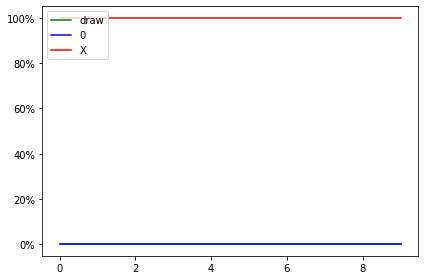

In [15]:
# agent_vs_agent(env, DummyAgent, MCTSPureExplorationAgent, n_episodes=10, params1={}, params2={'n_playouts': 20}, plot=True)
agent_vs_agent(env, DummyAgent, MCTSUCTAgent, n_episodes=10, params1={}, params2={'n_playouts': 20}, plot=True)

In [16]:
play(MCTSUCTAgent, game_env=env, params={'n_playouts': 50})

**        Tic Tac Toe Game        **
You are player 1 and you play the symbol O


# # #    |   1 2 3 
# # #    |   4 5 6 
# # #    |   7 8 9 
Where do you want to play? 
Unkown action, quitting...


100%|██████████| 10/10 [00:51<00:00,  5.19s/it, draw=0%, 0 wins=100%, X wins=0%]


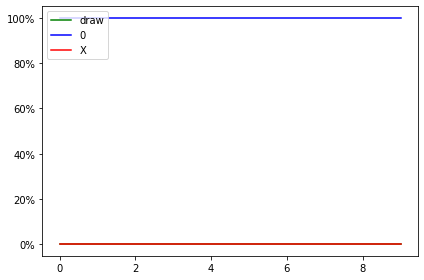

In [17]:
agent_vs_agent(env, MCTSUCTAgent, QLearningAgent, n_episodes=10, params1={'n_playouts': 50}, params2={'Q': Q_opt_Q_learning_cross.Q}, plot=True)